In [16]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cuda = torch.device("cuda:0")
print("compatibility gpu")
print(torch.cuda.get_device_capability(device=cuda))
a = torch.tensor([11,11], device=cuda)
print(a+a)

compatibility gpu
(8, 6)
tensor([22, 22], device='cuda:0')


In [31]:
def f(x,theta):
    return x+theta

In [32]:
mb = 1024
mu = 1.0
x0 = torch.distributions.MultivariateNormal(loc=torch.tensor([mu]),covariance_matrix=torch.tensor([[1.0]])).sample((mb,))

### Testing the loss

In [61]:
L_t = []
theta = 1
T = 20
xT = x0
for i in range(T):
    xT = f(xT,theta)
    L_t.append(torch.mean((xT-1)**2))

L = sum(L_t)
print(L)

tensor(2890.4126)


In [41]:
def deriv_L_T(t,theta):
    return 2*(t**2)*theta

## BPTT

### Gradient Descent

In [68]:
L_t = []
L=[]
L_Derv_t = []
L_Derv = []

T=20
lr = 0.000025
nb_epoch = 50
epoch = 0
theta=1
xT = x0


while epoch<nb_epoch:
    L_t = []
    L_Derv_t = []
    xT = torch.distributions.MultivariateNormal(loc=torch.tensor([1.0]),covariance_matrix=torch.tensor([[1.0]])).sample((mb,))

    for i in range(T):
        xT = f(xT,theta)
        L_t.append(torch.mean((xT-1)**2))
        L_Derv_t.append(deriv_L_T(i,theta))

    L.append(np.sum(L_t))
    L_Derv.append(np.sum(L_Derv_t))
    theta = theta - lr*np.sum(L_Derv_t)
    epoch+=1

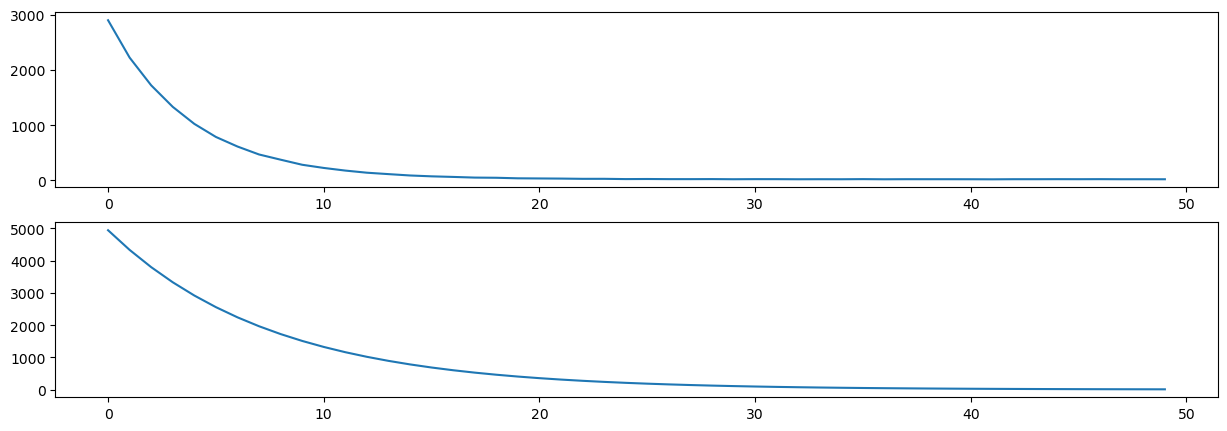

In [69]:
fig, axs = plt.subplots(2,1, figsize=(15,5))
axs[0].plot(L)
axs[1].plot(L_Derv)
plt.show()

### Gradient descent using Pytorch 

In [71]:
L_t = []
L = []
L_Derv_t = []
L_Derv = []

T = 20
lr = 0.000025
nb_epoch = 50
epoch = 0
theta = torch.tensor([1.0], requires_grad=True)

while epoch < nb_epoch:
    L_t = []
    xT = torch.distributions.MultivariateNormal(loc=torch.tensor([1.0]),covariance_matrix=torch.tensor([[1.0]])).sample((mb,))

    for i in range(T):
        xT = f(xT,theta)
        L_t.append(torch.mean((xT-1)**2))
        
    L_val = sum(L_t)
    L_val.backward()
    
    L.append(L_val.item()) 

    
    grad = theta.grad.detach().item() 
    L_Derv.append(grad)

    with torch.no_grad():
        theta -= lr * theta.grad 
    
    theta.grad.zero_()
    epoch += 1

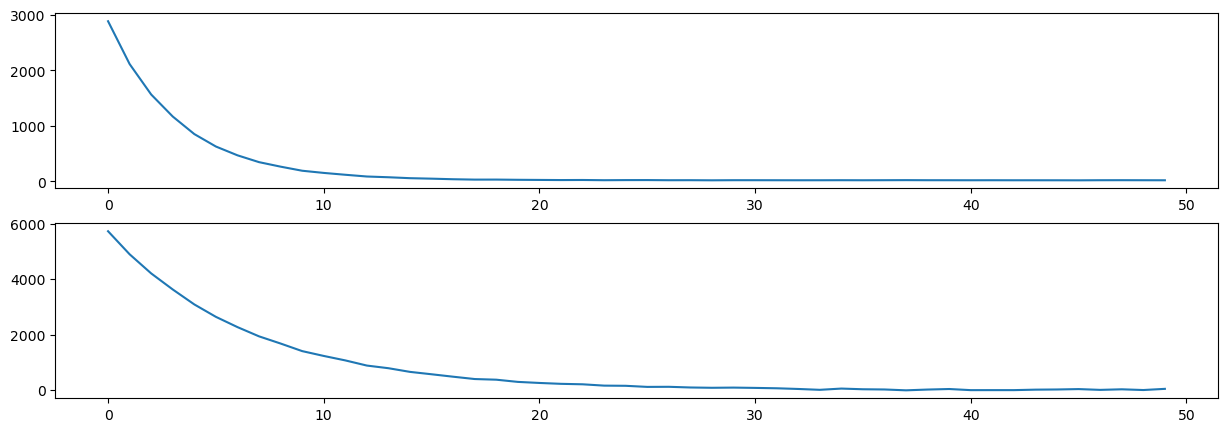

In [72]:
fig, axs = plt.subplots(2,1, figsize=(15,5))
axs[0].plot(L)
axs[1].plot(L_Derv)
plt.show()

## Truncated BPTT

In [73]:
L_t = []
L = []
L_Derv_t = []
L_Derv = []

T = 20
lr = 0.000025
nb_epoch = 50
epoch = 0
theta = torch.tensor([1.0], requires_grad=True)
tbtt_step = 5

while epoch < nb_epoch:
    L_t = []
    xT = torch.distributions.MultivariateNormal(loc=torch.tensor([1.0]),covariance_matrix=torch.tensor([[1.0]])).sample((mb,))

    for i in range(T):
        xT = f(xT,theta)
        L_t.append(torch.mean((xT-1)**2))

        if (i+1) % tbtt_step ==0 or i==T-1 :
            L_val = sum(L_t)
            L_val.backward()      
            L.append(L_val.item()) 

            
            grad = theta.grad.detach().item() 
            L_Derv.append(grad)

            with torch.no_grad():
                theta -= lr * theta.grad 
            
            theta.grad.zero_()
            L_t = []
            xT = xT.detach()

   
    epoch += 1

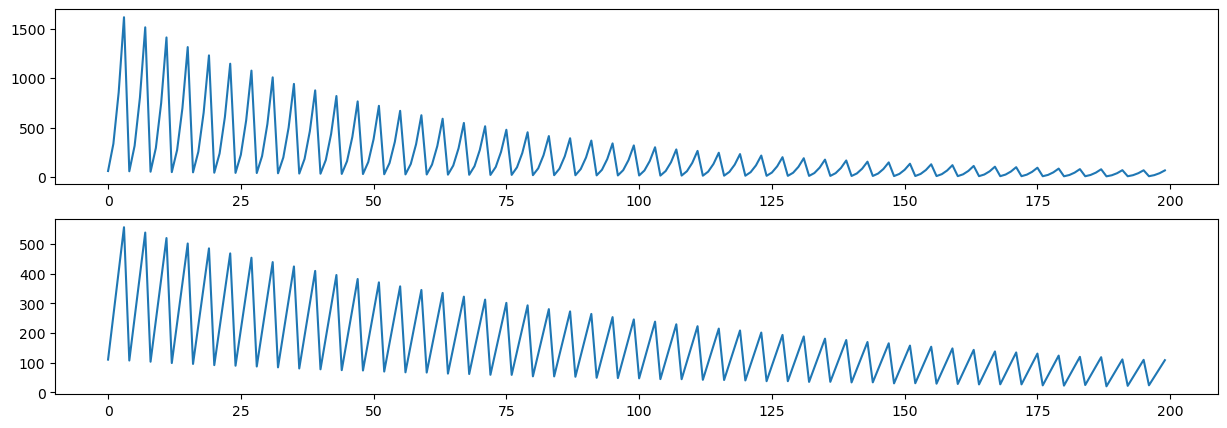

In [74]:
fig, axs = plt.subplots(2,1, figsize=(15,5))
axs[0].plot(L)
axs[1].plot(L_Derv)
plt.show()